In [1]:
%matplotlib ipympl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401 - needed for 3D projection

def plot_sag_surface(filename):
    # Load the raw data (columns: x, y, z)
    data = np.loadtxt(filename)

    # Extract columns
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]

    # Identify grid dimensions:
    # The C code writes points in nested loops: i over x, j over y.
    # Therefore: for each x, there are ny repeated y-values.
    # We reconstruct nx and ny from the data.
    # Count how many repeated x's appear.
    unique_x = np.unique(x)
    unique_y = np.unique(y)
    nx = unique_x.size
    ny = unique_y.size

    # Reshape into 2D arrays
    X = x.reshape(nx, ny)
    Y = y.reshape(nx, ny)
    Z = z.reshape(nx, ny)

    # Plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           linewidth=0, antialiased=True, cmap='viridis')

    ax.set_title("Image Slicer Sag Surface")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Sag (Z)")

    fig.colorbar(surf, shrink=0.6, aspect=12)
    plt.show()

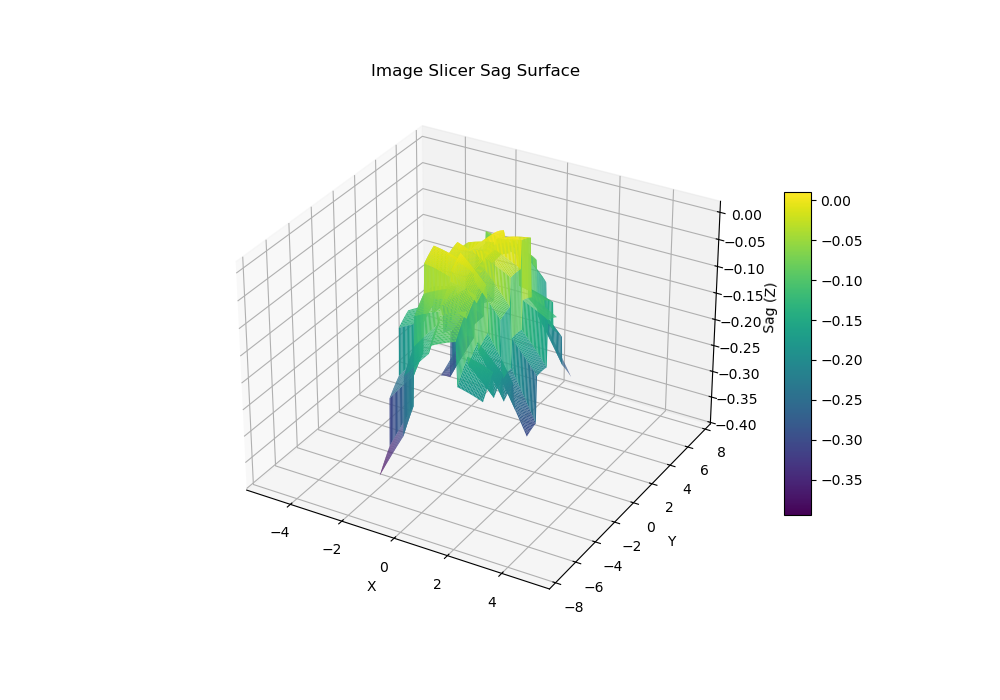

In [3]:
plot_sag_surface("test_output.txt")


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

from slicer_generation import *
from surface_solns import *

Initialize same params as in test.c

In [3]:
p = ImageSlicerParams(
    custom = 0,
    surface_type = 0,
    n_each = 4,
    n_rows = 3,
    n_cols = 1,
    angle_mode = 1,
    dalpha = 0,
    dbeta = 0,
    dgamma = 2,
    gamma_offset = 0,
    azps = 0,
    dsyx = 0,
    dsyz = 0,
    dsxy = 0,
    dsxz = 0,
    du = 0,
    alpha_cen = 0,
    beta_cen = 0,
    gamma_cen = 0,
    syx_cen = 0,
    syz_cen = 0,
    sxy_cen = 0,
    sxz_cen = 0,
    u_cen = 0,
    dx = 12,
    dy = 1,
    c = -1/100,
    k = 0,
    gx_width = 0,
    gx_depth = -3,
    gy_width = 0,
    gy_depth = 2
)
p_custom = np.array([])

p_custom = load_slice_params_file(0)
p = make_image_slicer_params_from_custom(p_custom)

Slicer transfer

In [6]:
data_file = "test_output.txt"
testxt, testyt, testl, testm, testn, testoutt, testoutln, testoutmn, testoutnn = np.loadtxt(data_file).T
"""
testxt = [testxt]
testyt = [testyt]
testl = [testl]
testm = [testm]
testn = [testn]
testoutt = [testoutt]
testoutln = [testoutln]
testoutmn = [testoutmn]
testoutnn = [testoutnn]
"""

'\ntestxt = [testxt]\ntestyt = [testyt]\ntestl = [testl]\ntestm = [testm]\ntestn = [testn]\ntestoutt = [testoutt]\ntestoutln = [testoutln]\ntestoutmn = [testoutmn]\ntestoutnn = [testoutnn]\n'

In [12]:
npts = len(testoutt)
pyout = np.empty((4, npts))

umin, umax = get_min_max_u(p, p_custom)
zmin, zmax = find_global_extrema_slicer(umin, umax, p, p_custom)

for i in range(npts):
    ray_in = RayIn(testxt[i], testyt[i], 0, testl[i], testm[i], testn[i])
    ray_out = ray_trace_slicer(ray_in, zmin, zmax, umin, umax, True, p, p_custom)
    pyout[0,i] = ray_out.t
    pyout[1,i] = ray_out.ln
    pyout[2,i] = ray_out.mn
    pyout[3,i] = ray_out.nn
    print("    >>>going to next")

IndexError: Requested slice (1, -1) out of bounds (9, 4)

In [10]:
for i in range(npts):
    if abs(testoutt[i] - pyout[0,i]) > 1e-8:
        print("Index {} is wrong".format(i))
    elif np.isnan(testoutt[i]) ^ np.isnan(pyout[0,i]):
        print("Index {} both values should be nan".format(i))

Transfer distance

In [6]:
data_file = "../src/test_output.txt"
testxt, testyt, testl, testm, testn, testoutt = np.loadtxt(data_file).T

FileNotFoundError: ../src/test_output.txt not found.

In [4]:
npts = len(testoutt)
pyout = np.empty(npts)
for i in range(npts):
    pyout[i] = transfer_dist_func(testxt[i], testyt[i], testl[i], testm[i], testn[i], p.c, p.k, p.alpha_cen, p.beta_cen, p.gamma_cen)

/Users/ellenlee/Documents/Zemax_dll/ifugen/python/surface_solns.py:113: RuntimeWarning: invalid value encountered in scalar divide
  return gsol/(-fsol + sgn*np.sqrt(fsol*fsol - dsol*gsol))


In [5]:
for i in range(npts):
    if abs(testoutt[i] - pyout[i]) > 1e-8:
        print("Index {} is wrong".format(i))
    elif np.isnan(testoutt[i]) ^ np.isnan(pyout[i]):
        print("Index {} both values should be nan".format(i))

Slicer sag

In [7]:
data_file = "test_output.txt"
result = np.loadtxt(data_file).T
testx = result[0]
testy = result[1]
testout = result[2]

In [8]:
npts = len(testout)
pyout = np.empty(npts)
for i in range(npts):
    pyout[i] = make_image_slicer(testx[i], testy[i], p, p_custom)

Validate outputs

In [10]:
for i in range(npts):
    if abs(testout[i] - pyout[i]) > 1e-8:
        print("Index {} is wrong".format(i))
    elif np.isnan(testout[i]) ^ np.isnan(pyout[i]):
        print("Index {} both values should be nan".format(i))
        print(f"testout is {testout[i]} and pyout is {pyout[i]}")
        print(f"testx is {testx[i]} and testy is {testy[i]}")

In [14]:
get_slicer_index(-1.492462311557789, -9, p, p_custom)

(0.0, -3.0)

In [15]:
make_image_slicer(-1.492462311557789, -9, p, p_custom)

nan

In [16]:
-3 // p.n_each

-1